In [ ]:
!mkdir -p ./kaggle
!cp /content/kaggle.json ~/.kaggle/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 65% 39.0M/60.3M [00:00<00:00, 204MB/s]
100% 60.3M/60.3M [00:00<00:00, 216MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/drive/MyDrive/emo_detection

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65242339.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65267116.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65275626.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_6529266.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65329617.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65338712.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65338797.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65387162.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65404494.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65426218.jpg  
  inflating: /content/drive/MyDrive/emo_detection/train/sad/Training_65430136.jpg  
  inflating: /content/driv

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from keras.utils import plot_model


## Setting up Directory to save model

In [ ]:
os.makedirs('test_dir', exist_ok = True)

In [ ]:
#define project name
project_name = 'FER_2013_Emotion_Detection'

#list of models

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation',
    'VGG16_transfer_Learning',
    'ResNet50_Transfer_Learning'
]

base_dir ='/content/drive/MyDrive/emo_detection'

#create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok = True)

#create a subdirectory for each model
for each_model in model_names:
  model_dir = os.path.join(project_dir, each_model)
  os,os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at" {project_dir}')

Project directory structure created at" /content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection


## Data Cleaning

In [ ]:
image_exts = ['jpeg', 'jpg', 'png']

# Path to the directory containing image classes and possibly other nested subdirectories
data_dir = '/content/drive/MyDrive/emo_detection/train'

#walk though all directories and files in the dataset
for root, dirs, files in os.walk(data_dir):
  for file in files:
    #construct the path to the current file
    file_path = os.path.join(root, file)

    try:
      file_type = imghdr.what(file_path)
      #if the file extension is not in the allowed list, remove it
      if file_type not in image_exts:
        print(f'Image not in exist list {file_path}')
        os.remove(file_path)

      else:
        #Proceed to process the image if needed
        img = cv2.imread(file_path)

    except Exception as e:
      #print out the issue and the path of the problematic file
      print(f'Issue with file {file_path}. Error: {e}')
      #Optionally, remove files that cause exceptions
      os.remove(file_path)


#Data Analysis

In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
  count ={}
  for item in os.listdir(directory):
    #Construct the full path to the item
    item_path = os.path.join(directory, item)

    #check if item is a directory
    if os.path.isdir(item_path):
      count[item]= len(os.listdir(item_path))

  #convert the counts directory to a dataframe for easy viewing and analysis
  #the index of the datafreame is set to the provided set name
  df = pd.DataFrame(count, index = [set_name])
  return df

#Paths to the training and testing directories
train_dir = '/content/drive/MyDrive/emo_detection/train'
test_dir = '/content/drive/MyDrive/emo_detection/test'

#count the files in the subdirectories of the training directory and print the result
train_count  = count_files_in_subdirs(train_dir, 'train')
print(train_count)

#count the files in the subdirectory of the testing directory and print the result
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


<Axes: >

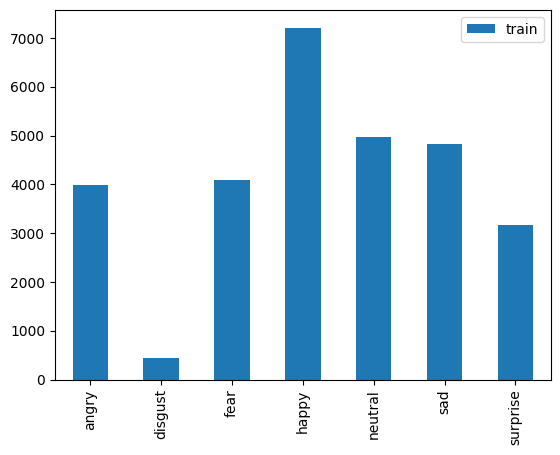

In [ ]:
train_count.transpose().plot(kind = 'bar')

<Axes: >

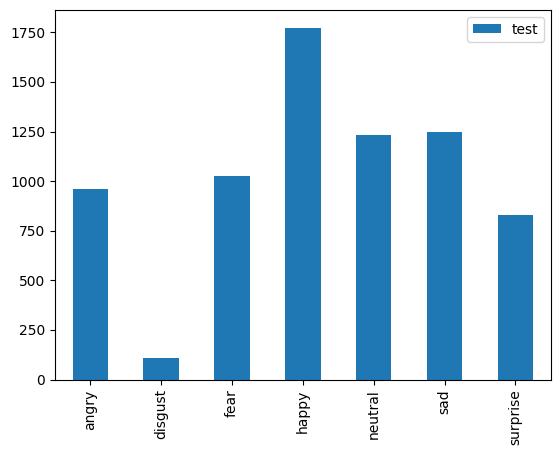

In [ ]:
test_count.transpose().plot(kind = 'bar')

#ploting one image for each emotion

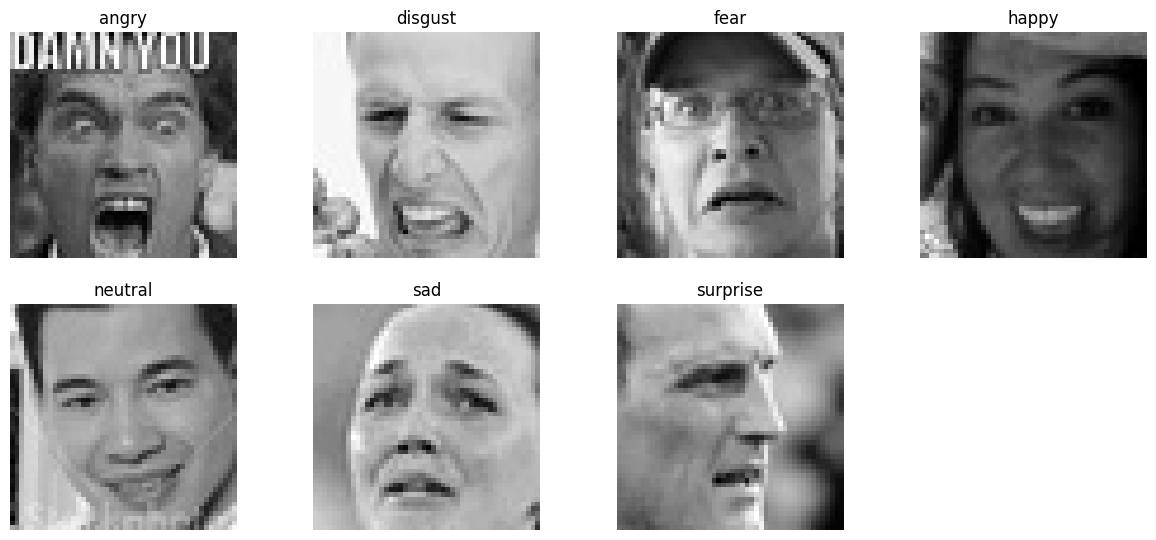

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize = (15,10))

for i, emotions in enumerate(emotions, 1):
  folder = os.path.join(train_dir, emotions)
  img_path = os.path.join(folder, os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img, cmap= 'gray')
  plt.title(emotions)
  plt.axis('off')

#plotting random images fron given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

In [ ]:
# Placeholder for the directory path
angry_directory_path = '/content/drive/MyDrive/emo_detection/train/angry'  # Replace with your directory path
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

NameError: name 'os' is not defined

In [ ]:
# Placeholder for the directory path
disgust_directory_path = '/content/drive/MyDrive/emo_detection/train/disgust'  # Replace with your directory path
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

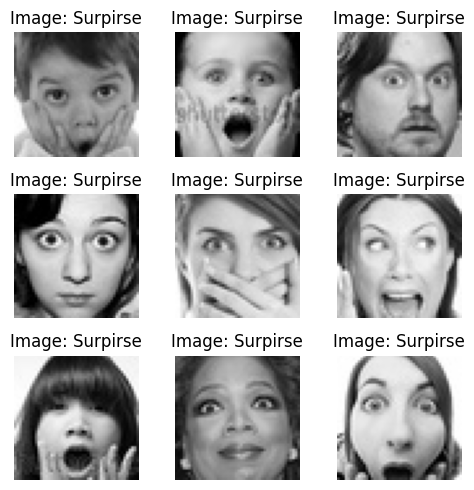

In [ ]:
# Placeholder for the directory path
surpirse_directory_path = '/content/drive/MyDrive/emo_detection/train/surprise'  # Replace with your directory path
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

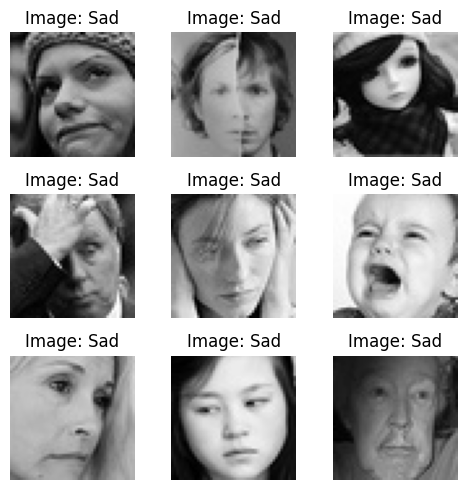

In [ ]:
sad_directory_path = '/content/drive/MyDrive/emo_detection/train/sad'
plot_images_from_directory(sad_directory_path, class_name ="Sad")

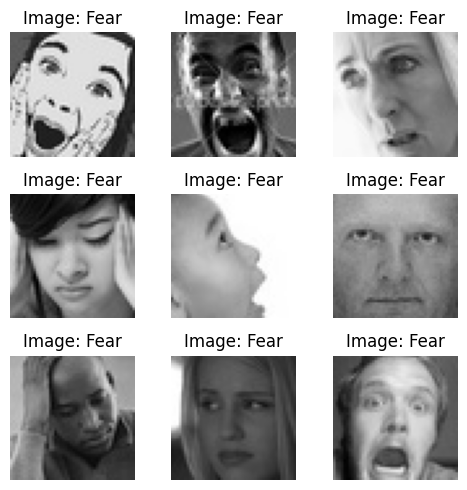

In [ ]:

fear_directory_path = '/content/drive/MyDrive/emo_detection/train/fear'
plot_images_from_directory(fear_directory_path, class_name= 'Fear')

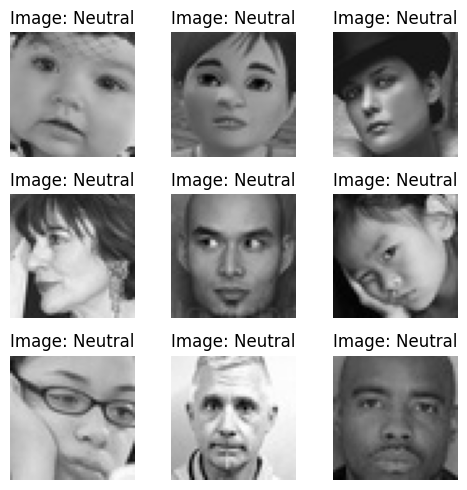

In [ ]:

neutral_directory_path = '/content/drive/MyDrive/emo_detection/train/neutral'
plot_images_from_directory(neutral_directory_path, class_name= 'Neutral')

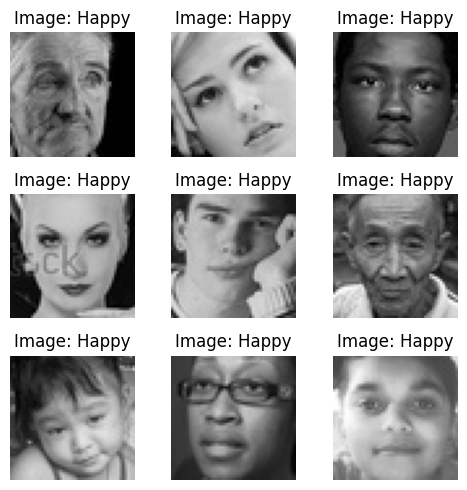

In [ ]:

happy_directory_path = '/content/drive/MyDrive/emo_detection/train/happy'
plot_images_from_directory(neutral_directory_path, class_name= 'Happy')

# Checking shapes and channels.


In [ ]:
image = '/content/drive/MyDrive/emo_detection/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image) # Default load in color format.

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/drive/MyDrive/emo_detection/train/angry/Training_10118481.jpg'

# Load the image in grayscale
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# If the image is loaded successfully, print its pixel values
if img is not None:
    # print(img)
    print("Shape:", img.shape)  # This should now print (48, 48)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
# define paths to the train and validation
train_data_dir= '/content/drive/MyDrive/emo_detection/train'
test_data_dir = '/content/drive/MyDrive/emo_detection/test'

In [ ]:
#set parameer
img_width , img_height = 48, 48
batch_size = 64
epochs = 64
num_classes = 7

In [ ]:
#rescale the pixel values (0-255) to the [0,1] interval
data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)


In [ ]:
#automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'training'

)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset = 'validation'
)

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels: ", train_class_labels)

# aCCESSING CLASS LABELs for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels: ", validation_class_labels)

# accessing class labels for the test data
test_class_labels = test_generator.class_indices
print("Test class labels: ", test_class_labels)


Training class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Test class labels:  {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
# Initialising the CNN
model = Sequential()

# Adding comvolution layers with activation on the same line for clarity
model.add(Conv2D(32, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', input_shape = (img_width, img_height, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size =(3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size = (3,3), padding= 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size = (3,3), kernel_initializer = 'glorot_uniform', padding = 'same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size = (3,3), padding ='same', kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

# Flatten and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#Output layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

In [ ]:
#compile model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

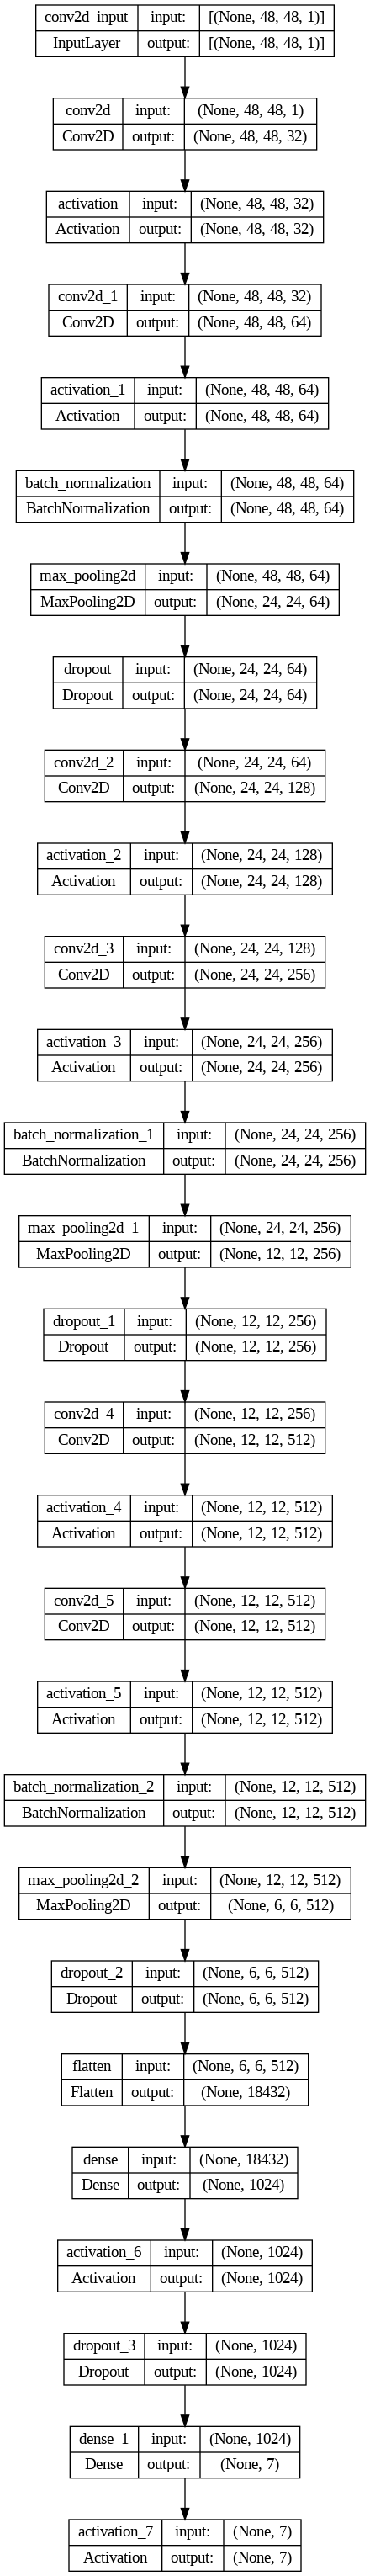

In [ ]:
plot_model(model, to_file ='/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes = True, show_layer_names = True)

#calbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
#callback to save the model checkpint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only= True,
                             verbose =1,
                             mode = 'min',
                             monitor= 'val_loss')

In [ ]:
#callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.2,
                          patience = 6,
                          min_lr = 0.00001,
                          verbose = 1)

In [ ]:
#Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path, 'training.log'))

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
# Aggregating all callback into a list
callbacks= [checkpoint, earlystop, reduce_lr, csv_logger]

# Calculating steps for epoch

In [ ]:
train_generator.samples

22968

In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

# model Training

In [ ]:
history = model.fit(train_generator,
                    epochs = 10,
                    steps_per_epoch = train_steps_per_epoch,
                    validation_data = validation_generator,
                    validation_steps = validation_steps_epoch,
                    callbacks = callbacks,
                    )

# plotting Performance Metrics

In [ ]:
def plot_training_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range  = range(len(acc))
  plt.figure(figsize= (20,5))

  #plot Training and validation accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs_range, acc, label = 'Training Accuracy')
  plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and validation Accuracy')

  #plot training and validation loss
  plt.subplot(1,2,1)
  plt.plot(epochs_range, loss, label= 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'upper right')
  plt.title('Training and validation Loss')

  plt.show()

# Model Evaluation

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(tedt_generator)
print("Final Train accuracy= {:.2f}, validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

# Plotting confusion matrix

In [ ]:
#Assuming Your True Classes and predicting classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps = np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = lsit(test_generator.class_indices.keys())

#generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)


#plotting with seaborn
plt.figure(figsize = (10,8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap= 'Blues', xticklabels= class_labels, yticklabels= class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
report = classification_report(true_classes, predicted_classes, traget_names = class_labels)
print("Classification Report : \n",report)

 # Making Prediction

In [ ]:
# emotion classes for the dataset
Emotion_classes = ["Angry", 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

#Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

#Selecting a random batch from the test  generator
random_batch = np.random.randint(0, len(test_generator)-1)

#Selecting random image indices from the batch
random_img_index = np.random.randint(0, batch_size, 10)


#setting up the plot
fig, axes = plt.subplots(nrows = 2, ncols=5, figsize = (10,5), subplot_kw= {'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
  # fetching the random image eatch label
  random_img = test_generator[random_batch][0][random_img_index[i]]
  random_img_label = np.argmax(test_generator[random_batch][1][random_img_index[i]], axis=0)

  #Making a prediction using the model
  model_prediction = np.argmax(model.predict(tf.expand_dims(random_img, axis=0), verbose = 0), axis=1)

  #display the img
  ax.imshow(random_img.squeeze(), cmap = 'gray')

  #Setting the title with true and predicted labels, colored based on correctnes
  color  = 'green' if Emotion_classes[random_img_label] == Emotion_classes[model_prediction] else 'red'
  ax.set_title(f"True: {Emotion_classes[random_img_label]}\nPredicted: {Emotion_classes[model_prediction]}", color = color)


plt.tight_layout()
plt.show()


# Model 2 : Image Augmentation

In [ ]:
#Define Paths to the train and validation directories
train_data_dir= '/content/drive/MyDrive/emo_detection/train'
test_data_dir = '/content/drive/MyDrive/emo_detection/test'

#Set some parameters
img_width , img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7

#image data generator
data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range= 0.2,
    height_shift_range =0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode= 'nearest',
    validation_split = 0.2
)

test_data_generator = ImageDataGenerator(rescale = 1./255)

#Automatically retrive image and classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subnet = 'training'
)

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subnet = 'validation'
)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale'
)

In [ ]:
# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))



In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/FER_2013_Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case



In [ ]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks
)

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# Model 3: Transfer Learning VGGNET

In [ ]:
# Define paths to the train and validation directories
train_data_dir= '/content/drive/MyDrive/emo_detection/train'
test_data_dir = '/content/drive/MyDrive/emo_detection/test'


# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1. / 255,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1. / 255,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

In [ ]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

In [ ]:
classes

In [ ]:
# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(7, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/VGG16_Transfer_Learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=50,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    class_weight=class_weights_dict,
                    callbacks = callbacks
                    )

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# Model 4: Transfer learning - Resnet50

In [ ]:
# Define paths to the train and validation directories
train_data_dir= '/content/drive/MyDrive/emo_detection/train'
test_data_dir = '/content/drive/MyDrive/emo_detection/test'

In [ ]:
# Batch size for data generators
batch_size = 64

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]
                                  rotation_range=10,  # Random rotation within range [-10,10] degrees
                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]
                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]
                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]
                                  horizontal_flip=True,  # Random horizontal flip
                                  fill_mode='nearest'  # Fill mode for handling newly created pixels
                                 )

# Configuration for testing data (only rescaling)
test_datagen = ImageDataGenerator(
                                  rescale=1 / 255.  # Rescale pixel values to [0,1]
                                 )

# Data generators for training and testing data
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,  # Directory containing training data
                                                    class_mode="categorical",  # Classification mode for categorical labels
                                                    target_size=(224, 224),  # Resize input images to (224,224)
                                                    color_mode='rgb',  # Color mode for images (RGB)
                                                    shuffle=True,  # Shuffle training data
                                                    batch_size=batch_size,  # Batch size for training
                                                    subset='training'  # Subset of data (training)
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,  # Directory containing testing data
                                                  class_mode="categorical",  # Classification mode for categorical labels
                                                  target_size=(224, 224),  # Resize input images to (224,224)
                                                  color_mode="rgb",  # Color mode for images (RGB)
                                                  shuffle=False,  # Do not shuffle testing data
                                                  batch_size=batch_size  # Batch size for testing
                                                 )


# Intriducing class weights for imbalanced data

In [ ]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():

    model = Sequential([
                      ResNet50V2,
                      Dropout(0.25),
                      BatchNormalization(),
                      Flatten(),
                      Dense(64, activation='relu'),
                      BatchNormalization(),
                      Dropout(0.5),
                      Dense(7,activation='softmax')
                    ])
    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=30,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

In [ ]:
plot_training_history(train_history)

In [ ]:
model = keras.saving.load_model("/content/drive/MyDrive/emo_detection/FER_2013_Emotion_Detection/ResNet50_Transfer_Learning/ResNet50_Transfer_Learning.keras")

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

# AUC ROC plot for each class

In [ ]:
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

In [ ]:
y_encoded = pd.get_dummies(true_labels).astype(int).values
preds_encoded = pd.get_dummies(pred_labels).astype(int).values

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_encoded[:,i], preds_encoded[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,5))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve for {classes[i]} (area = {roc_auc[i]:0.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

In [ ]:
model.save("Resnet_model_version_2.keras")